# Feature Engineering


In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import time

plt.style.use('ggplot')
start_time = dt.datetime.now()
%matplotlib inline
import warnings



warnings.filterwarnings('ignore')


In [2]:
%%time
data=pd.read_csv('final_cleaned_data.csv')
data.shape

CPU times: user 49.2 ms, sys: 7.75 ms, total: 56.9 ms
Wall time: 57.5 ms


(96397, 10)

In [3]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0


In [4]:
data['Date']=pd.to_datetime(data['Date'])
data['Merch description'] = data['Merch description'].str.upper()
data['Merch zip'] = data['Merch zip'].astype('int64') 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96397 entries, 0 to 96396
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  int64         
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  int64         
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 7.4+ MB


In [6]:
def count_zeros(data):
    count=0
    for i in data:
        if i==0:
            count+=1
    return count

In [7]:
statistics_of_data = []
for col in ["Recnum","Cardnum","Merchnum","Merch description","Merch state","Merch zip","Transtype","Fraud"]:
    statistics_of_data.append((col,
                             'categorical',
                             data[col].notnull().sum(),
                             f'{data[col].notnull().sum()/data.shape[0]*100}%',
                             count_zeros(data[col]),
                             data[col].nunique(),
                            data[col].mode()[0]
                            
                             ))
stats_df = pd.DataFrame(statistics_of_data, columns=['Field Name', 'Field Type','# Records Have Values', '% Populated', '# Zeros','# Unique Values', 'Most Common',])
stats_df



,Field Name,Field Type,# Records Have Values,% Populated,# Zeros,# Unique Values,Most Common
0,Recnum,categorical,96397,100.0%,0,96397,1
1,Cardnum,categorical,96397,100.0%,0,1643,5142148452
2,Merchnum,categorical,96397,100.0%,0,13117,930090121224
3,Merch description,categorical,96397,100.0%,0,12964,GSA-FSS-ADV
4,Merch state,categorical,96397,100.0%,0,91,TN
5,Merch zip,categorical,96397,100.0%,0,4595,38118
6,Transtype,categorical,96397,100.0%,0,1,P
7,Fraud,categorical,96397,100.0%,95338,2,0


In [8]:
statistics_of_data1 = []
for col in ['Date','Amount']:
    statistics_of_data1.append((col,
                             'Numerical',
                             data[col].notnull().sum(),
                             f'{data[col].notnull().sum()/data.shape[0]*100}%',
                             count_zeros(data[col]),
                             data[col].min(),
                             data[col].max(),
                             data[col].mode()[0]
                            
                             ))

stats_df1 = pd.DataFrame(statistics_of_data1, columns=['Field Name', 'Field Type','# Records Have Values', '% Populated', '# Zeros','Min', 'Max','Most Common',])
stats_df1


,Field Name,Field Type,# Records Have Values,% Populated,# Zeros,Min,Max,Most Common
0,Date,Numerical,96397,100.0%,0,2010-01-01 00:00:00,2010-12-31 00:00:00,2010-02-28 00:00:00
1,Amount,Numerical,96397,100.0%,0,0.01,47900.0,3.62


# Creating  Benford's Law variables for Merchnum and Cardnum

In [9]:
bf= data.copy()

In [10]:
bf.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0


In [11]:

bf['amount_100']=(bf['Amount']*100).astype(str)
bf['first_digit'] = bf['amount_100'].str[0]
dropfedex= bf[bf['Merch description'].str.contains('FEDEX')]
droplist=dropfedex.index.tolist()
bf1=bf.drop(droplist)
bf1['bin']=bf1['first_digit'].apply(lambda x: "low" if x=="1" else ("low" if x==2 else "high")) 

In [12]:
bf1.shape

(84622, 13)

In [13]:
bf1.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_100,first_digit,bin
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,3142.0,3,high
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,17849.0,1,low
7,8,5142191182,2010-01-01,6098208200062,MIAMI COMPUTER SUPPLY,OH,45429,P,230.32,0,23032.0,2,high
8,9,5142258629,2010-01-01,602608969534,FISHER SCI ATL,GA,30091,P,62.11,0,6211.0,6,high
13,14,5142124791,2010-01-01,5725000466504,CDW*GOVERNMENT INC,IL,60061,P,106.89,0,10689.0,1,low


In [14]:
bf1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84622 entries, 1 to 96396
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             84622 non-null  int64         
 1   Cardnum            84622 non-null  int64         
 2   Date               84622 non-null  datetime64[ns]
 3   Merchnum           84622 non-null  object        
 4   Merch description  84622 non-null  object        
 5   Merch state        84622 non-null  object        
 6   Merch zip          84622 non-null  int64         
 7   Transtype          84622 non-null  object        
 8   Amount             84622 non-null  float64       
 9   Fraud              84622 non-null  int64         
 10  amount_100         84622 non-null  object        
 11  first_digit        84622 non-null  object        
 12  bin                84622 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(7)
memory 

In [15]:
card_bf=bf1.groupby(['Cardnum','bin']).agg({'bin' : ['count']}).reset_index()
card_bf.columns=['Cardnum','bin','count']
card_bf= card_bf.pivot_table(index='Cardnum',columns='bin',values='count',aggfunc='sum').reset_index()
card_bf.columns=['Cardnum','n_high','n_low']
card_bf=card_bf.fillna(1)


In [16]:
card_bf.head()

,Cardnum,n_high,n_low
0,5142110002,1.0,1.0
1,5142110081,4.0,1.0
2,5142110313,1.0,2.0
3,5142110402,10.0,1.0
4,5142110434,1.0,1.0


In [17]:
from math import exp


In [18]:
# calculating R, 1/R , U n, t, U_smoothed
c=3
n_mid=15
card_bf['R']=(1.096 * card_bf['n_low']/card_bf['n_high'])
card_bf['1/R']=(1/card_bf['R'])
card_bf['U']=list(map(lambda x, y : max(x,y),card_bf['R'],card_bf['1/R']))
card_bf['n']=card_bf['n_high'] + card_bf['n_low']
card_bf['t']=((card_bf['n']-n_mid)/c)

card_bf['U_smoothed']=list(map(lambda x,y : (1+ (x-1)/(1 + exp(-y))),card_bf['U'],card_bf['t']))
card_bf['U_smoothed']=card_bf['U_smoothed']

In [19]:
card_bf.head()

,Cardnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,5142110002,1.0,1.0,1.0960,0.912409,1.096000,2.0,-4.333333,1.001244
1,5142110081,4.0,1.0,0.2740,3.649635,3.649635,5.0,-3.333333,1.091267
2,5142110313,1.0,2.0,2.1920,0.456204,2.192000,3.0,-4.000000,1.021440
3,5142110402,10.0,1.0,0.1096,9.124088,9.124088,11.0,-1.333333,2.694754
4,5142110434,1.0,1.0,1.0960,0.912409,1.096000,2.0,-4.333333,1.001244


In [20]:
bf1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84622 entries, 1 to 96396
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             84622 non-null  int64         
 1   Cardnum            84622 non-null  int64         
 2   Date               84622 non-null  datetime64[ns]
 3   Merchnum           84622 non-null  object        
 4   Merch description  84622 non-null  object        
 5   Merch state        84622 non-null  object        
 6   Merch zip          84622 non-null  int64         
 7   Transtype          84622 non-null  object        
 8   Amount             84622 non-null  float64       
 9   Fraud              84622 non-null  int64         
 10  amount_100         84622 non-null  object        
 11  first_digit        84622 non-null  object        
 12  bin                84622 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(7)
memory 

In [21]:
merch_bf=bf1.groupby(['Merchnum','bin']).agg({'bin' : ['count']}).reset_index()
merch_bf.columns=['Merchnum','bin','count']
merch_bf= merch_bf.pivot_table(index='Merchnum',columns='bin',values= 'count',aggfunc='sum').reset_index()
merch_bf.columns=['Merchnum','n_high','n_low']
merch_bf=merch_bf.fillna(1)

In [22]:
merch_bf.head()

,Merchnum,n_high,n_low
0,003100006NOT6,1.0,1.0
1,004740006ABC6,1.0,1.0
2,005590006PNB6,1.0,1.0
3,014430619 14,1.0,1.0
4,014938913 51,1.0,1.0


In [23]:
# calculating R, 1/R , U n, t, U_smoothed
c=3
n_mid=15
merch_bf['R']=(1.096 * merch_bf['n_low']/merch_bf['n_high'])
merch_bf['1/R']=(1/merch_bf['R'])
merch_bf['U']=list(map(lambda x, y : max(x,y),merch_bf['R'],merch_bf['1/R']))
merch_bf['n']=merch_bf['n_high'] + merch_bf['n_low']
merch_bf['t']=((merch_bf['n']-n_mid)/c)

merch_bf['U_smoothed']=list(map(lambda x,y : (1+ (x-1)/(1 + exp(-y))),merch_bf['U'],merch_bf['t']))
merch_bf['U_smoothed']=merch_bf['U_smoothed']

In [24]:
merch_bf.head()

,Merchnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,003100006NOT6,1.0,1.0,1.096,0.912409,1.096,2.0,-4.333333,1.001244
1,004740006ABC6,1.0,1.0,1.096,0.912409,1.096,2.0,-4.333333,1.001244
2,005590006PNB6,1.0,1.0,1.096,0.912409,1.096,2.0,-4.333333,1.001244
3,014430619 14,1.0,1.0,1.096,0.912409,1.096,2.0,-4.333333,1.001244
4,014938913 51,1.0,1.0,1.096,0.912409,1.096,2.0,-4.333333,1.001244


In [25]:
card_bf['Cardnum']=card_bf['Cardnum'].apply(str)

In [26]:
card_bf.set_index('Cardnum',inplace =True)
card_Ustar=pd.DataFrame(card_bf['U_smoothed'])
card_Ustar.sort_values(['U_smoothed'],ascending=False).head(3)

,U_smoothed
Cardnum,
5142194617,33.743794
5142240823,22.266612
5142176413,14.740518


In [27]:
merch_bf['Merchnum']=merch_bf['Merchnum'].apply(str)

In [28]:
merch_bf.set_index('Merchnum',inplace =True)
merch_Ustar=pd.DataFrame(merch_bf['U_smoothed'])
merch_Ustar.sort_values(['U_smoothed'],ascending=False).head(3)

,U_smoothed
Merchnum,
991808369338,165.145985
881107835,87.591241
993620810220,72.992701


# Day of Week Target Encoding

In [29]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0


In [30]:
data['Dow']=data.Date.apply(lambda x: calendar.day_name[x.weekday()])


In [31]:
# Separate the OOT
train_test=data[data.Date<'2010-11-01']

In [32]:
#Statistical Smoothing

c=3;nmid=15;y_avg=train_test['Fraud'].mean()
y_dow=train_test.groupby('Dow')['Fraud'].mean()
num=train_test.groupby('Dow').size()
y_dow_smooth=y_avg+(y_dow-y_avg)/(1+np.exp(-(num-nmid)/c))
data['Dow_risk']=data.Dow.map(y_dow_smooth)

In [33]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Dow,Dow_risk
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,Friday,0.025994
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,Friday,0.025994
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,Friday,0.025994
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,Friday,0.025994
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,Friday,0.025994


In [34]:
# delete files that we don't need any more to free up memory
del train_test

In [35]:
y_dow=y_dow.reset_index()
cats=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_dow['Dow']=pd.Categorical(y_dow['Dow'],categories=cats,ordered=True)
y_dow=y_dow.sort_values('Dow')
y_dow=y_dow.set_index('Dow')

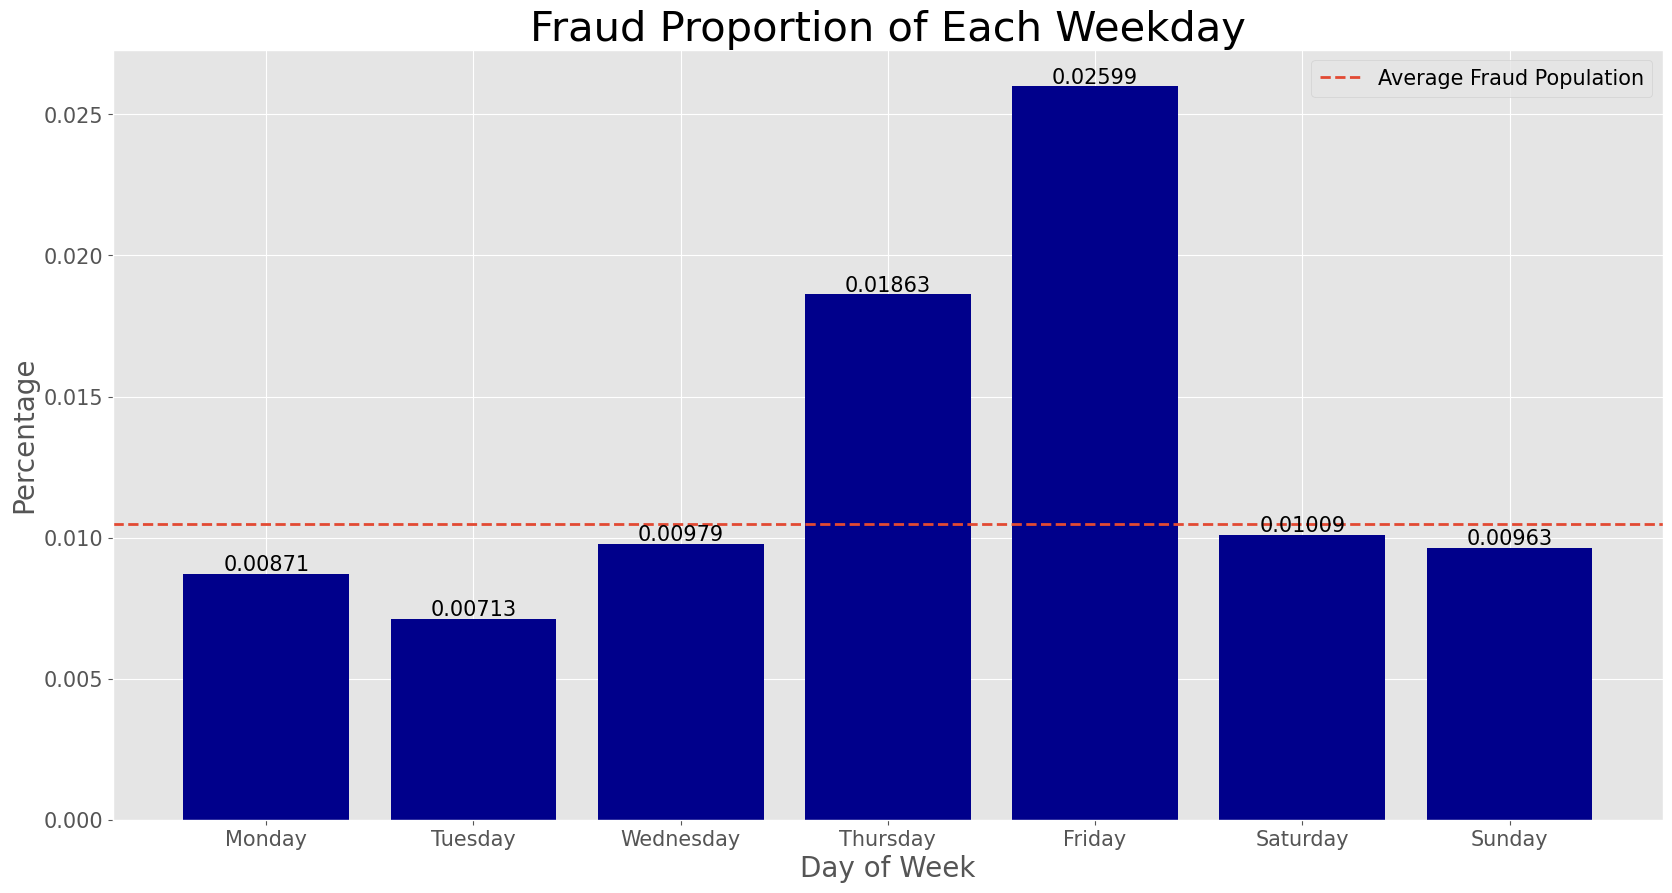

In [36]:
#plot
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(20,10))
plt.bar(data=y_dow,x=y_dow.index,height='Fraud',color='darkblue')
#ax.set_ylim(bottom=.013)

ax.axhline(y=y_avg,ls='--',lw=2, label ='Average Fraud Population')

for i,v in enumerate(y_dow.index):
    ax.text(v,y_dow.loc[v,'Fraud']+0.0001,round(y_dow.loc[v,'Fraud'],5),horizontalalignment='center',fontsize=15)


    
plt.legend(['Average Fraud Population'],fontsize= 15)
plt.xlabel("Day of Week",fontsize=20)
plt.ylabel("Percentage",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Fraud Proportion of Each Weekday",fontsize=30)

plt.savefig('risktable.png')
plt.show()


# Creating Variables

In [37]:

df = data.copy()


In [38]:
print(df.shape)
df.info()

(96397, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96397 entries, 0 to 96396
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  int64         
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  int64         
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
 10  Dow                96397 non-null  object        
 11  Dow_risk           96397 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 8.8+ MB


In [39]:
start_convert = pd.Timestamp.now()

# Transform the data type of the values to string, enabling the ability to 
# merge specific values together to form variables.


cols = df.columns.difference(['Date', 'Fraud', 'Amount','Recnum','Dow_risk']) # Select all columns except Date, Fraud and Amount
df[cols] = df[cols].astype(str)

print('convert time', pd.Timestamp.now() - start_convert)
df.dtypes




convert time 0 days 00:00:00.062035


Recnum                        int64
Cardnum                      object
Date                 datetime64[ns]
Merchnum                     object
Merch description            object
Merch state                  object
Merch zip                    object
Transtype                    object
Amount                      float64
Fraud                         int64
Dow                          object
Dow_risk                    float64
dtype: object

#  Make new entities for variables

In [40]:
df['card_merch'] = df['Cardnum'] + df['Merchnum'] 

df['card_zip'] = df['Cardnum'] + df['Merch zip']

df['merch_zip']=df['Merchnum'] + df['Merch zip']

df['zip3'] =df['Merch zip'].str[:3]

df['card_zip3']=df['Cardnum'] +df['zip3']

df['card_merchdesc']= df['Cardnum'] + df['Merch description']

df['merchnum_desc']=df['Merchnum'] + df['Merch description']

df['card_merch_desc']=df['Cardnum']+ df['Merchnum'] + df['Merch description']



#df['card_state'] = df['Cardnum'] + df['Merch state']

# df['merch_state']=df['Merchnum']+df['Merch state']

#df['card_merch_state'] = df['Cardnum'] + df['Merchnum'] + df['Merch state']
#df['card_merch_zip'] = df['Cardnum'] + df['Merchnum'] + df['Merch zip']

In [41]:
df.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'Dow',
       'Dow_risk', 'card_merch', 'card_zip', 'merch_zip', 'zip3', 'card_zip3',
       'card_merchdesc', 'merchnum_desc', 'card_merch_desc'],
      dtype='object')

In [42]:
attributes=list(df.iloc[:,np.r_[1,3,12,13,14,16,17,18,19]].columns)
attributes

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'merch_zip',
 'card_zip3',
 'card_merchdesc',
 'merchnum_desc',
 'card_merch_desc']

In [43]:
len(attributes)

9

In [44]:
df.shape

(96397, 20)

In [45]:
# start_convert = pd.Timestamp.now()

# cols = df.columns.difference(['Date','Recnum','Fraud', 'Amount'])
# df[cols] = df[cols].apply(lambda x: pd.to_numeric(x, errors='ignore'))

# print('convert time', pd.Timestamp.now() - start_convert)
# df.dtypes




In [46]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Dow,Dow_risk,card_merch,card_zip,merch_zip,zip3,card_zip3,card_merchdesc,merchnum_desc,card_merch_desc
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,Friday,0.025994,51421904395509006296254,514219043938118,550900629625438118,381,5142190439381,5142190439FEDEX SHP 12/23/09 AB#,5509006296254FEDEX SHP 12/23/09 AB#,51421904395509006296254FEDEX SHP 12/23/09 AB#
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803,P,31.42,0,Friday,0.025994,514218397361003026333,51421839731803,610030263331803,180,5142183973180,5142183973SERVICE MERCHANDISE #81,61003026333SERVICE MERCHANDISE #81,514218397361003026333SERVICE MERCHANDISE #81
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,Friday,0.025994,51421317214503082993600,514213172120706,450308299360020706,207,5142131721207,5142131721OFFICE DEPOT #191,4503082993600OFFICE DEPOT #191,51421317214503082993600OFFICE DEPOT #191
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,Friday,0.025994,51421484525509006296254,514214845238118,550900629625438118,381,5142148452381,5142148452FEDEX SHP 12/28/09 AB#,5509006296254FEDEX SHP 12/28/09 AB#,51421484525509006296254FEDEX SHP 12/28/09 AB#
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,Friday,0.025994,51421904395509006296254,514219043938118,550900629625438118,381,5142190439381,5142190439FEDEX SHP 12/23/09 AB#,5509006296254FEDEX SHP 12/23/09 AB#,51421904395509006296254FEDEX SHP 12/23/09 AB#


In [47]:
df.shape

(96397, 20)

In [48]:
df1=df.copy()
final=df.copy()
df1['check_date']=df1.Date
df1['check_record']=df1.Recnum

final.shape

(96397, 20)

## Velocity/counts and days since# 

In [49]:
print(final.shape)
numstart=len(final.columns)
numstart

(96397, 20)


20

In [50]:
# import pandas as pd
# import numpy as np
# import datetime as dt

# def create_day_since_variables(df, entity):
#     df_temp = df[[entity, 'Date', 'Recnum', 'Amount']]
#     df_temp['check_date'] = df_temp['Date']
#     df_temp['check_record'] = df_temp['Recnum']
#     df_merged = pd.merge(df_temp, df_temp, on=entity, suffixes=('', '_check'))
#     df_filtered = df_merged[(df_merged['Recnum'] > df_merged['check_record'])][['Recnum', 'Date', 'check_date']]
#     df_grouped = df_filtered.groupby('Recnum')[['Date', 'check_date']].last()
#     mapper = (df_grouped['Date'] - df_grouped['check_date']).dt.days
#     result = df['Recnum'].map(mapper)
#     result.fillna((df['Date'] - pd.to_datetime('2010-01-01')).dt.days, inplace=True)
#     return result.rename(entity + '_day_since')

# def create_frequency_amount_variables(df, entity):
#     result = pd.DataFrame()
#     for time in [0, 1, 3, 7, 14, 30, 60]:
#         time_mask = (df['check_date'] >= (df['Date'] - dt.timedelta(time))) & (df['Recnum'] >= df['check_record'])
#         df_filtered = df[time_mask][['Recnum', entity, 'Amount']]
#         col_name = entity + '_count_' + str(time)
#         df_grouped = df_filtered.groupby('Recnum')[entity].count()
#         result[col_name] = df['Recnum'].map(df_grouped)
#         result[entity + '_avg_' + str(time)] = df['Recnum'].map(df_filtered.groupby('Recnum')['Amount'].mean())
#         result[entity + '_max_' + str(time)] = df['Recnum'].map(df_filtered.groupby('Recnum')['Amount'].max())
#         result[entity + '_med_' + str(time)] = df['Recnum'].map(df_filtered.groupby('Recnum')['Amount'].median())
#         result[entity + '_total_' + str(time)] = df['Recnum'].map(df_filtered.groupby('Recnum')['Amount'].sum())
#         result[entity + '_actual/avg_' + str(time)] = df['Amount'] / result[entity + '_avg_' + str(time)]
#         result[entity + '_actual/max_' + str(time)] = df['Amount'] / result[entity + '_max_' + str(time)]
#         result[entity + '_actual/med_' + str(time)] = df['Amount'] / result[entity + '_med_' + str(time)]
#         result[entity + '_actual/total_' + str(time)] = df['Amount'] / result[entity + '_total_' + str(time)]
#     return result

# def create_variables(df, attributes):
#     result = df.copy()
#     for entity in attributes:
#         day_since = create_day_since_variables(df, entity)
#         freq_amt = create_frequency_amount_variables(df, entity)
#         result = pd.concat([result, day_since, freq_amt], axis=1)
#     return result

# attributes  # list of entity attributes
# final = create_variables(df, attributes)


In [51]:
import timeit


In [52]:
%%time
start=timeit.default_timer()

for entity in attributes:
    try: print(entity,'Run time for this entity---> {}s'.format(timeit.default_timer()-st))
    except: 
        print('')
    st=timeit.default_timer()
    
    
# Day- since variables:

    df_l=df1[['Recnum','Date',entity]]
    df_r=df1[['check_record','check_date',entity,'Amount']]
    temp=pd.merge(df_l,df_r, left_on=entity,right_on=entity)
    temp1=temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']].groupby('Recnum')[['Date','check_date']].last()
 


    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since']=final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date-pd.to_datetime('2010-01-01')).dt.days,inplace =True)
    print('\n' + entity + '_day_since --->Done')
    
    
# # Frequency & amount variables:
    
    for time in [0,1,3,7,14,30,60]:
        temp2=temp[(temp.check_date >=(temp.Date -dt.timedelta(time))) & \
                    (temp.Recnum >=temp.check_record)] [['Recnum',entity,'Amount']]
        
        col_name =entity + '_count_' + str(time)
        mapper2 =temp2.groupby('Recnum')[entity].count()
        final[col_name]= final.Recnum.map(mapper2)
        print(col_name + '--> Done')
        final[entity +'_avg_'+ str(time)]=final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity +'_max_'+ str(time)]=final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity +'_med_'+ str(time)]=final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity +'_total_'+ str(time)]=final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity +'_actual/avg_'+ str(time)]=final['Amount'] / final[entity +'_avg_'+ str(time)]
        final[entity +'_actual/max_'+ str(time)]=final['Amount'] / final[entity +'_max_'+ str(time)]
        final[entity +'_actual/med_'+ str(time)]=final['Amount'] / final[entity +'_med_'+ str(time)]
        final[entity +'_actual/total_'+ str(time)]=final['Amount'] / final[entity +'_total_'+ str(time)]
        print(entity + '_amount_variables_over_ ' + str(time) + '---> Done')
        
        
    del df_l
    del df_r
    del temp
    del temp1
    del temp2
    del mapper2
    
        
print('Total run time :{}mins'.format((timeit.default_timer()-st)/60)) 
    



Cardnum_day_since --->Done
Cardnum_count_0--> Done
Cardnum_amount_variables_over_ 0---> Done
Cardnum_count_1--> Done
Cardnum_amount_variables_over_ 1---> Done
Cardnum_count_3--> Done
Cardnum_amount_variables_over_ 3---> Done
Cardnum_count_7--> Done
Cardnum_amount_variables_over_ 7---> Done
Cardnum_count_14--> Done
Cardnum_amount_variables_over_ 14---> Done
Cardnum_count_30--> Done
Cardnum_amount_variables_over_ 30---> Done
Cardnum_count_60--> Done
Cardnum_amount_variables_over_ 60---> Done
Merchnum Run time for this entity---> 6.538985625011264s

Merchnum_day_since --->Done
Merchnum_count_0--> Done
Merchnum_amount_variables_over_ 0---> Done
Merchnum_count_1--> Done
Merchnum_amount_variables_over_ 1---> Done
Merchnum_count_3--> Done
Merchnum_amount_variables_over_ 3---> Done
Merchnum_count_7--> Done
Merchnum_amount_variables_over_ 7---> Done
Merchnum_count_14--> Done
Merchnum_amount_variables_over_ 14---> Done
Merchnum_count_30--> Done
Merchnum_amount_variables_over_ 30---> Done
Merch

In [53]:
# freq_vars = sum(['_actual/total' in col for col in final.columns])

# print("Total count of frequency variables:", freq_vars)


In [54]:
print(final.shape)
print('#new variable is',len(final.columns)-numstart)
numstart=len(final.columns)

(96397, 596)
#new variable is 576


# velocity  change variables (relative velocity variabls)

In [55]:
%%time
start = timeit.default_timer()

# Velocity change variables
for entity in attributes:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            entity_count_d = final[entity + '_count_' + d]
            entity_count_dd = final[entity + '_count_' + dd]
            entity_total_d = final[entity + '_total_' + d]
            entity_total_dd = final[entity + '_total_' + dd]
            
            final[entity + '_count_' + d + '_by_' + dd] = entity_count_d / entity_count_dd / float(dd)
            final[entity + '_total_amount_' + d + '_by_' + dd] = entity_total_d / entity_total_dd / float(dd)

print('Run time: {}s'.format((timeit.default_timer() - start)))


Run time: 0.12337837500672322s
CPU times: user 45.5 ms, sys: 20.7 ms, total: 66.2 ms
Wall time: 123 ms


In [56]:
# import re
# vel_vars = [col for col in final.columns if re.search(r'(_count_|_total_amount_)\d{2}', col)]
# print(len(vel_vars))

In [57]:
print(final.shape)
print('#new variables are',len(final.columns) - numstart)
numstart=len(final.columns)

(96397, 740)
#new variables are 144


In [58]:
final.to_csv('make_var_part_1',index=False)

# Velocity day since ratio variables( Velocity Density Ratio variables)



In [59]:
final_new=final.copy()

In [60]:
print(final_new.shape)



(96397, 740)


In [61]:
numstart=len(final_new.columns)
numstart

740

In [62]:
%%time
start = timeit.default_timer()

for entity in attributes:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final_new[entity +'_vdratio_'+d] =\
            final_new[entity+'_count_'+d+'_by_'+ dd]/(final[entity+'_day_since']+1)
          

CPU times: user 19.5 ms, sys: 9.24 ms, total: 28.8 ms
Wall time: 28.1 ms


In [63]:
print(final_new.shape)
print('#new variables are',len(final_new.columns) - numstart)
numstart=len(final_new.columns)

(96397, 758)
#new variables are 18


# Counts by entities ( #number of unique for particular field)
# Entity-Related Unique Count Variables


In [64]:
%%time
start = timeit.default_timer()
for entity in attributes:
    for field in attributes:
        st=timeit.default_timer()
        if entity != field:
            new_attributes= f'{entity}_{field}_nunique'
            if new_attributes not in list(final_new.columns):
                mapper3=final_new.groupby(entity)[field].nunique()
                final_new[new_attributes]=final_new[entity].map(mapper3)
        print(f'run time for entity {entity} in field {field}' + '--> Done')
        
print('total run time : {}mins'.format((timeit.default_timer()-start/60)))

run time for entity Cardnum in field Cardnum--> Done
run time for entity Cardnum in field Merchnum--> Done
run time for entity Cardnum in field card_merch--> Done
run time for entity Cardnum in field card_zip--> Done
run time for entity Cardnum in field merch_zip--> Done
run time for entity Cardnum in field card_zip3--> Done
run time for entity Cardnum in field card_merchdesc--> Done
run time for entity Cardnum in field merchnum_desc--> Done
run time for entity Cardnum in field card_merch_desc--> Done
run time for entity Merchnum in field Cardnum--> Done
run time for entity Merchnum in field Merchnum--> Done
run time for entity Merchnum in field card_merch--> Done
run time for entity Merchnum in field card_zip--> Done
run time for entity Merchnum in field merch_zip--> Done
run time for entity Merchnum in field card_zip3--> Done
run time for entity Merchnum in field card_merchdesc--> Done
run time for entity Merchnum in field merchnum_desc--> Done
run time for entity Merchnum in field c

In [65]:
print(final_new.shape)
print('#new variables are',len(final_new.columns) - numstart)
numstart=len(final_new.columns)

(96397, 830)
#new variables are 72


#  Frequency mappers Variables


In [66]:
df2=data.copy()
df2['check_date']=df2.Date
df2['check_recnum']=df2.Recnum
df_2=df2[['Recnum','Date','Amount','Cardnum','Merchnum']]
df_s=df2[['check_recnum','check_date','Amount','Cardnum','Merchnum']]
temp2=pd.merge(df_2,df_s,left_on='Cardnum',right_on='Cardnum')


groupers=['Cardnum']
for grouper in groupers:
    for d in [0,1]:
        for dd in [3,7,14,30]:
            numerator_df=temp2[(temp2.check_date>=(temp2.Date-dt.timedelta(d)))
                              & (temp2.Recnum>=temp2.check_recnum)]
            
            denominator_df=temp2[(temp2.check_date>=(temp2.Date-dt.timedelta(dd)))
                              & (temp2.Recnum>=temp2.check_recnum)]
            
            
            
            numerator=numerator_df.groupby(grouper)['Recnum'].count()/dd

            denominator=denominator_df.groupby(grouper)['Recnum'].count()/dd
            
            colname='relative_velocity_count_by_'+ grouper +'_'+ str(d) +'_days_over_'+ str(dd)
            final_new[colname]=final_new[grouper].map(numerator)/final_new[grouper].map(denominator)
            

In [67]:
print(final_new.shape)
print('#new variables are',len(final_new.columns) - numstart)
numstart=len(final_new.columns)

(96397, 838)
#new variables are 8


# Variability Variables


In [68]:
attributes

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'merch_zip',
 'card_zip3',
 'card_merchdesc',
 'merchnum_desc',
 'card_merch_desc']

In [69]:
%%time
start=timeit.default_timer()

for entity in attributes:
    try: print(entity,'Run time for this entity---> {}s'.format(timeit.default_timer()-st))
    except: 
        print('')
    st=timeit.default_timer()
    df_l=df1[['Recnum','Date',entity,'Amount']]
    df_r=df1[['check_record','check_date',entity,'Amount']]
    temp=pd.merge(df_l,df_r, left_on=entity,right_on=entity)
    
    
    
    for time in [0,1,3,7,14,30]:
        temp2=temp[(temp.check_date >=(temp.Date - dt.timedelta(time))) & \
                    (temp.Recnum >=temp.check_record)] [['Recnum','check_record',entity,'Amount_x','Amount_y']]
        temp2['Amount_diff']=temp2['Amount_y']-temp2['Amount_x']
        
        
        col_name =entity + '_variability_avg_' + str(time)
        
        mapper2 =temp2.groupby('Recnum')['Amount_diff'].mean()
        
        final_new[col_name]= final_new.Recnum.map(mapper2)
        print(col_name+'----> Done')
        
        
        col_name =entity + '_variability_max_' + str(time)
        
        mapper2 =temp2.groupby('Recnum')['Amount_diff'].max()
        
        final_new[col_name]= final_new.Recnum.map(mapper2)
        print(col_name + '----> Done')
        
        col_name =entity + '_variability_med_' + str(time)
        
        mapper2 =temp2.groupby('Recnum')['Amount_diff'].median()
        
        final_new[col_name]= final_new.Recnum.map(mapper2)
        print(col_name + '----> Done')
        
        
        print(entity + ' amount variable over past ' + str(time) + '---->Done')
        
        
             
    del df_l
    del df_r
    del temp
    del temp2
    
    
        
print('Total run time :{}mins'.format((timeit.default_timer()-st)/60)) 
    

Cardnum Run time for this entity---> 5.886755458006519s
Cardnum_variability_avg_0----> Done
Cardnum_variability_max_0----> Done
Cardnum_variability_med_0----> Done
Cardnum amount variable over past 0---->Done
Cardnum_variability_avg_1----> Done
Cardnum_variability_max_1----> Done
Cardnum_variability_med_1----> Done
Cardnum amount variable over past 1---->Done
Cardnum_variability_avg_3----> Done
Cardnum_variability_max_3----> Done
Cardnum_variability_med_3----> Done
Cardnum amount variable over past 3---->Done
Cardnum_variability_avg_7----> Done
Cardnum_variability_max_7----> Done
Cardnum_variability_med_7----> Done
Cardnum amount variable over past 7---->Done
Cardnum_variability_avg_14----> Done
Cardnum_variability_max_14----> Done
Cardnum_variability_med_14----> Done
Cardnum amount variable over past 14---->Done
Cardnum_variability_avg_30----> Done
Cardnum_variability_max_30----> Done
Cardnum_variability_med_30----> Done
Cardnum amount variable over past 30---->Done
Merchnum Run time 

In [70]:
print(final_new.shape)
print('#new variables are',len(final_new.columns) - numstart)
numstart=len(final_new.columns)

(96397, 1000)
#new variables are 162


In [71]:
final_new.to_csv('make_var_part_3',index=False)

In [72]:
len(final_new.columns)

1000

In [73]:
attributes

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'merch_zip',
 'card_zip3',
 'card_merchdesc',
 'merchnum_desc',
 'card_merch_desc']

#  Remove redundant columns

In [74]:
final_new.set_index('Recnum',inplace=True)

In [75]:
%%time
print(final_new.shape)
final_new=final_new.T.drop_duplicates().T
final_new.shape

(96397, 999)
CPU times: user 19.4 s, sys: 14 s, total: 33.4 s
Wall time: 38.9 s


(96397, 957)

In [76]:
final_new.columns.values.tolist()

['Cardnum',
 'Date',
 'Merchnum',
 'Merch description',
 'Merch state',
 'Merch zip',
 'Transtype',
 'Amount',
 'Fraud',
 'Dow',
 'Dow_risk',
 'card_merch',
 'card_zip',
 'merch_zip',
 'zip3',
 'card_zip3',
 'card_merchdesc',
 'merchnum_desc',
 'card_merch_desc',
 'Cardnum_day_since',
 'Cardnum_count_0',
 'Cardnum_avg_0',
 'Cardnum_max_0',
 'Cardnum_med_0',
 'Cardnum_total_0',
 'Cardnum_actual/avg_0',
 'Cardnum_actual/max_0',
 'Cardnum_actual/med_0',
 'Cardnum_actual/total_0',
 'Cardnum_count_1',
 'Cardnum_avg_1',
 'Cardnum_max_1',
 'Cardnum_med_1',
 'Cardnum_total_1',
 'Cardnum_actual/avg_1',
 'Cardnum_actual/max_1',
 'Cardnum_actual/med_1',
 'Cardnum_actual/total_1',
 'Cardnum_count_3',
 'Cardnum_avg_3',
 'Cardnum_max_3',
 'Cardnum_med_3',
 'Cardnum_total_3',
 'Cardnum_actual/avg_3',
 'Cardnum_actual/max_3',
 'Cardnum_actual/med_3',
 'Cardnum_actual/total_3',
 'Cardnum_count_7',
 'Cardnum_avg_7',
 'Cardnum_max_7',
 'Cardnum_med_7',
 'Cardnum_total_7',
 'Cardnum_actual/avg_7',
 'Cardn

In [77]:
len(final_new.columns)

957

In [78]:
final_vars =final_new.iloc[:,np.r_[8,10,19:len(final_new.columns)]]

In [79]:
final_vars.head()

,Fraud,Dow_risk,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_actual/avg_0,Cardnum_actual/max_0,...,card_merch_desc_variability_med_3,card_merch_desc_variability_avg_7,card_merch_desc_variability_max_7,card_merch_desc_variability_med_7,card_merch_desc_variability_avg_14,card_merch_desc_variability_max_14,card_merch_desc_variability_med_14,card_merch_desc_variability_avg_30,card_merch_desc_variability_max_30,card_merch_desc_variability_med_30
Recnum,,,,,,,,,,,,,,,,,,,,,
1,0,0.025994,0.0,1,3.62,3.62,3.62,3.62,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.025994,0.0,1,31.42,31.42,31.42,31.42,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.025994,0.0,1,178.49,178.49,178.49,178.49,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.025994,0.0,1,3.62,3.62,3.62,3.62,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.025994,0.0,2,3.62,3.62,3.62,7.24,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
final_vars.shape

(96397, 940)

In [81]:
final_vars.to_csv('candidate_vars_to_use.csv')

In [82]:
print('Duration:',pd.datetime.now()-start_time)

Duration: 0:06:10.293679
